In [1]:
from neo4j import GraphDatabase
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import yaml
from collections import Counter

# Configuration des plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration chargée")

Configuration chargée


In [3]:
class GraphLoader:
    def __init__(self, uri, user, password, database, cache_path, min_collaborations):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database
        self.cache_path = cache_path
        self.min_collaborations = min_collaborations
    
    def close(self):
        self.driver.close()
    
    def load_collaborations(self):
        """Charge toutes les collaborations depuis Neo4j"""
        query = """
        MATCH (a1:Author)-[:AUTHORED]->(p:Paper)<-[:AUTHORED]-(a2:Author)
        WHERE a1.authorId < a2.authorId
        WITH a1, a2, count(p) as num_collabs
        WHERE num_collabs >= $min_collabs
        RETURN a1.authorId as source, 
               a1.name as source_name,
               a2.authorId as target,
               a2.name as target_name,
               num_collabs as weight
        """
        with self.driver.session(database=self.database) as session:
            result = session.run(query, min_collabs=self.min_collaborations)
            return [dict(record) for record in result]
    
    def build_graph(self, collaborations):
        """Construit le graphe NetworkX"""
        G = nx.Graph()
        
        for collab in collaborations:
            # Ajouter les arêtes avec leurs poids
            G.add_edge(
                collab['source'],
                collab['target'],
                weight=collab['weight']
            )
            
            # Ajouter les attributs des nœuds
            if 'name' not in G.nodes[collab['source']]:
                G.nodes[collab['source']]['name'] = collab['source_name']
            if 'name' not in G.nodes[collab['target']]:
                G.nodes[collab['target']]['name'] = collab['target_name']
        
        return G
    
    def save_to_cache(self, G):
        """Sauvegarde le graphe dans le cache"""
        os.makedirs(os.path.dirname(self.cache_path), exist_ok=True)
        with open(self.cache_path, 'wb') as f:
            pickle.dump(G, f)
        print(f"💾 Graphe sauvegardé dans: {self.cache_path}")
    
    def load_from_cache(self):
        """Charge le graphe depuis le cache"""
        if os.path.exists(self.cache_path):
            with open(self.cache_path, 'rb') as f:
                G = pickle.load(f)
            print(f"Graphe chargé depuis cache: {self.cache_path}")
            return G
        return None

In [4]:
loader = GraphLoader(
    uri=config['neo4j']['uri'],
    user=config['neo4j']['user'],
    password=config['neo4j']['password'],
    database=config['neo4j']['database'],
    cache_path=config['graph']['cache_path'],
    min_collaborations=config['graph']['min_collaborations']
)

print("Loader initialisé")

Loader initialisé


In [5]:
G = loader.load_from_cache()

if G is None:
    print("Pas de cache trouvé. Chargement depuis Neo4j...")
    print("Cela peut prendre quelques minutes...")
    
    # Charger les collaborations
    collaborations = loader.load_collaborations()
    print(f"{len(collaborations)} collaborations chargées")
    
    # Construire le graphe
    G = loader.build_graph(collaborations)
    print(f"Graphe construit")
    
    # Sauvegarder dans le cache
    loader.save_to_cache(G)
else:
    print("Graphe chargé depuis le cache")

# Fermer la connexion Neo4j
loader.close()

Graphe chargé depuis cache: data/graph_cache.pkl
Graphe chargé depuis le cache


In [6]:
print("\n INFORMATIONS SUR LE GRAPHE")
print("="*50)
print(f" Nombre de nœuds (auteurs): {G.number_of_nodes()}")
print(f" Nombre d'arêtes (collaborations): {G.number_of_edges()}")
print(f" Densité du graphe: {nx.density(G):.6f}")
print(f" Graphe connexe: {'Oui' if nx.is_connected(G) else 'Non'}")
print(f" Nombre de composantes connexes: {nx.number_connected_components(G)}")

# Degré moyen
degrees = [d for n, d in G.degree()]
print(f" Degré moyen: {sum(degrees)/len(degrees):.2f}")
print(f" Degré max: {max(degrees)}")
print(f" Degré min: {min(degrees)}")


 INFORMATIONS SUR LE GRAPHE
 Nombre de nœuds (auteurs): 19861
 Nombre d'arêtes (collaborations): 357484
 Densité du graphe: 0.001813
 Graphe connexe: Non
 Nombre de composantes connexes: 1674
 Degré moyen: 36.00
 Degré max: 568
 Degré min: 1


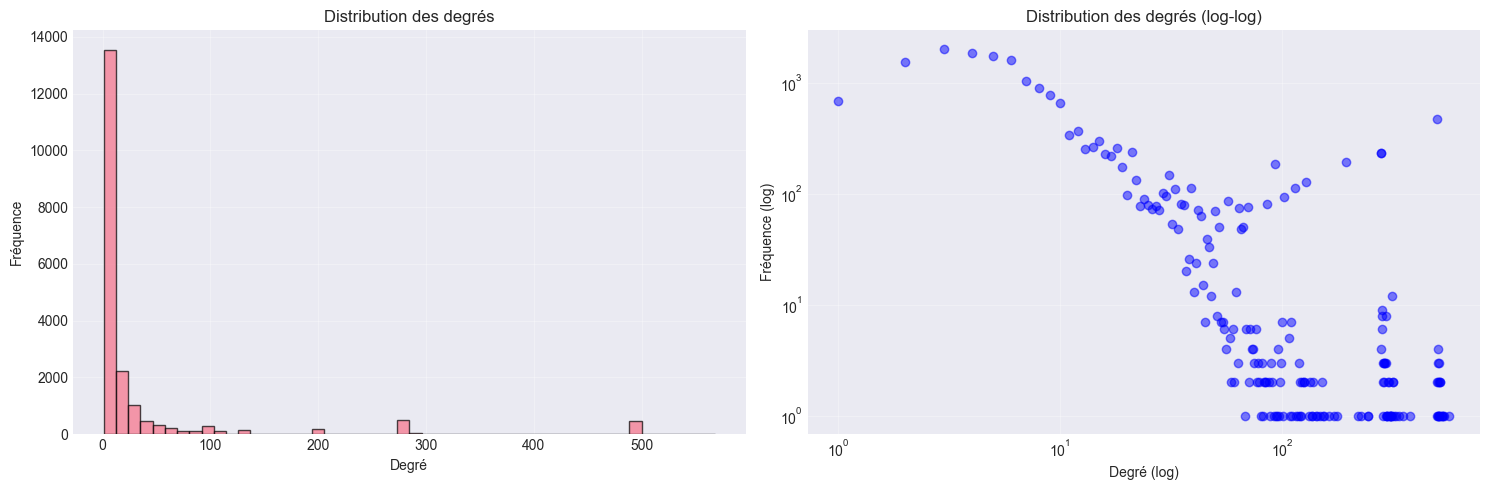

In [8]:
degrees = [d for n, d in G.degree()]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme
axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degré')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des degrés')
axes[0].grid(True, alpha=0.3)

# Log-log plot (pour vérifier si c'est une loi de puissance)
degree_counts = Counter(degrees)
degrees_sorted = sorted(degree_counts.keys())
counts = [degree_counts[d] for d in degrees_sorted]

axes[1].loglog(degrees_sorted, counts, 'bo', alpha=0.5)
axes[1].set_xlabel('Degré (log)')
axes[1].set_ylabel('Fréquence (log)')
axes[1].set_title('Distribution des degrés (log-log)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
degree_dict = dict(G.degree())
top_authors = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("\n Top 10 auteurs par nombre de collaborateurs:")
print("="*60)
for i, (author_id, degree) in enumerate(top_authors, 1):
    name = G.nodes[author_id].get('name', 'Unknown')
    print(f"{i:2d}. {name:30s} - {degree:3d} collaborateurs")


 Top 10 auteurs par nombre de collaborateurs:
 1. Sharan Narang                  - 568 collaborateurs
 2. Naman Goyal                    - 535 collaborateurs
 3. M. Seltzer                     - 531 collaborateurs
 4. M. Tsimpoukelli                - 528 collaborateurs
 5. Christoph Feichtenhofer        - 525 collaborateurs
 6. Dieuwke Hupkes                 - 517 collaborateurs
 7. Po-Yao (Bernie) Huang          - 515 collaborateurs
 8. Kenneth Heafield               - 515 collaborateurs
 9. Todor Mihaylov                 - 514 collaborateurs
10. Punit Singh Koura              - 514 collaborateurs



  ANALYSE DES POIDS DES COLLABORATIONS
Nombre moyen de co-publications: 1.02
Maximum de co-publications: 17
Minimum de co-publications: 1


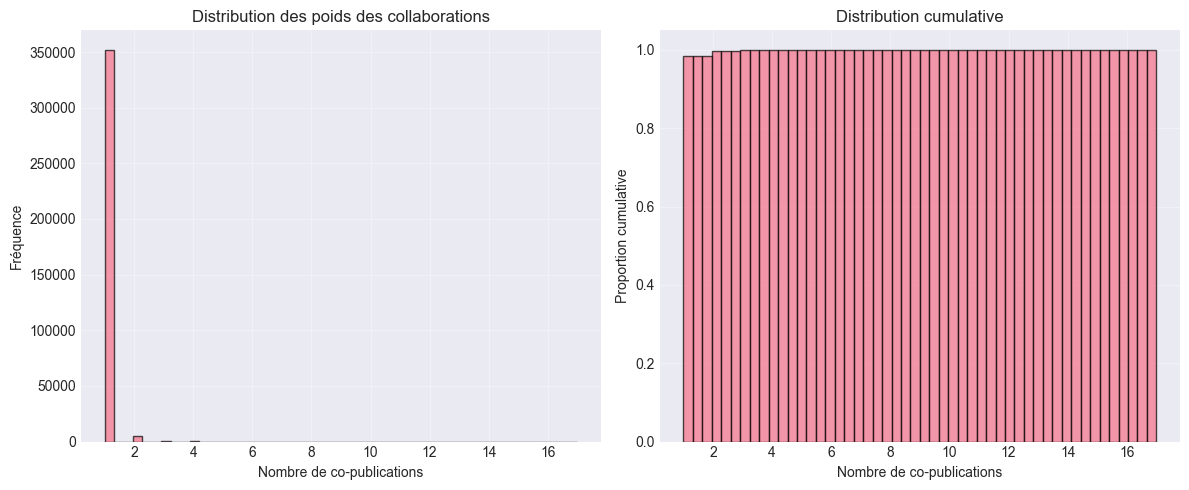

In [7]:
weights = [G[u][v]['weight'] for u, v in G.edges()]

print("\n  ANALYSE DES POIDS DES COLLABORATIONS")
print("="*50)
print(f"Nombre moyen de co-publications: {sum(weights)/len(weights):.2f}")
print(f"Maximum de co-publications: {max(weights)}")
print(f"Minimum de co-publications: {min(weights)}")

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(weights, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Nombre de co-publications')
plt.ylabel('Fréquence')
plt.title('Distribution des poids des collaborations')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(weights, bins=50, edgecolor='black', alpha=0.7, cumulative=True, density=True)
plt.xlabel('Nombre de co-publications')
plt.ylabel('Proportion cumulative')
plt.title('Distribution cumulative')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
if not nx.is_connected(G):
    components = list(nx.connected_components(G))
    component_sizes = [len(c) for c in components]
    
    print(f"\n COMPOSANTES CONNEXES")
    print("="*50)
    print(f"Nombre de composantes: {len(components)}")
    print(f"Taille de la plus grande composante: {max(component_sizes)}")
    print(f"Taille de la plus petite composante: {min(component_sizes)}")
    
    # Prendre la plus grande composante pour les analyses futures
    largest_cc = max(components, key=len)
    G_main = G.subgraph(largest_cc).copy()
    
    print(f"\n Plus grande composante extraite:")
    print(f"   Nœuds: {G_main.number_of_nodes()}")
    print(f"    Arêtes: {G_main.number_of_edges()}")
    
    # Sauvegarder la plus grande composante
    with open('../data/graph_main_component.pkl', 'wb') as f:
        pickle.dump(G_main, f)
    print(" Composante principale sauvegardée")
else:
    print("\n Le graphe est connexe, pas besoin d'extraction")
    G_main = G


 COMPOSANTES CONNEXES
Nombre de composantes: 1674
Taille de la plus grande composante: 10363
Taille de la plus petite composante: 2

 Plus grande composante extraite:
   Nœuds: 10363
    Arêtes: 300869
 Composante principale sauvegardée


In [8]:
graph_info = {
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    'density': nx.density(G),
    'is_connected': nx.is_connected(G),
    'num_components': nx.number_connected_components(G),
    'avg_degree': sum(degrees)/len(degrees),
    'max_degree': max(degrees),
    'min_degree': min(degrees)
}

# Sauvegarder dans un fichier
import json
with open('../results/graph_info.json', 'w') as f:
    json.dump(graph_info, f, indent=2)

print("\n Informations du graphe sauvegardées dans results/graph_info.json")
print("\n Chargement du graphe terminé!")
print(" Le graphe est maintenant prêt pour la détection de communautés")


 Informations du graphe sauvegardées dans results/graph_info.json

 Chargement du graphe terminé!
 Le graphe est maintenant prêt pour la détection de communautés
